In [1]:
import functools
from typing import List, Tuple

# Plotting imports.
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "serif", "font.size": 15})
%matplotlib inline

# Third-party imports.
import cirq

import networkx as nx
import numpy as np

# Mitiq imports.
from mitiq import benchmarks, ddd

In [2]:
# Random seed for circuit generation.
seed = 1

# Total number of shots to use.
shots: int = 10000

# Qubits to use on the experiment.
qubits = [0, 1, 2]

# Average results over this many trials (circuit instances) at each depth.
trials = 3

# Clifford depths.
depths = [10, 20, 30]

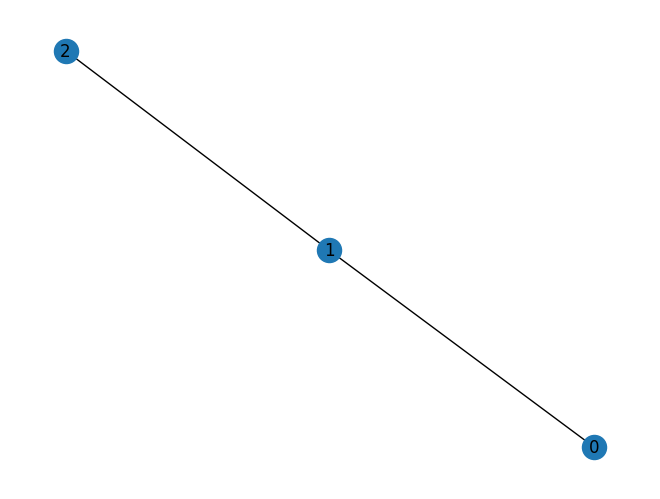

In [3]:
# Assume chain-like connectivity
topology = nx.Graph()
topology.add_edges_from([(0, 1), (1, 2)])
nx.draw(topology, with_labels=True)

# Add reversed edges to topology graph.
# This is important to represent CNOT gates with target and control reversed.
topology = nx.to_directed(topology)

In [4]:
def get_circuit(depth: int, seed: int) -> Tuple[cirq.Circuit, List[int]]:
    circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
        nlayers=depth,
        two_qubit_gate_prob=1.0,
        connectivity_graph=topology,
        two_qubit_gate_name="CNOT",
        seed=seed,
        return_type="cirq",
    )
    return circuit, correct_bitstring

In [5]:
def execute(
    circuit: cirq.Circuit,
    shots: int,
    correct_bitstring: List[int],
    is_noisy: bool = True,
) -> float:
    """Executes the input circuit(s) and returns ⟨A⟩, where
    A = |correct_bitstring⟩⟨correct_bitstring| for each circuit.
    """
    # This is useful to understand if DDD gates are inserted into the circuit.
    print(f"Executing circuit with {len(list(circuit.all_operations()))} gates.")
    if is_noisy:
        # Simulate systematic dephasing (coherent RZ) on each qubit for each moment.
        circuit_to_run = circuit.with_noise(cirq.rz(0.05))
    else:
        circuit_to_run = circuit.copy()

    circuit_to_run += cirq.measure(*sorted(circuit.all_qubits()), key="m")
    backend = cirq.DensityMatrixSimulator()

    result = backend.run(circuit_to_run, repetitions=shots)
    expval = result.measurements["m"].tolist().count(correct_bitstring) / shots
    return expval

In [6]:
from mitiq import ddd

rule = ddd.rules.yy

In [7]:
true_values, noisy_values = [], []
ddd_values = []

noise_scaled_expectation_values = []

for depth in depths:
    print("Status: On depth", depth, end="\n\n")

    true_depth_values, noisy_depth_values, ddd_depth_values = [], [], []

    for trial in range(trials):
        # Local seed is calculated in this way to ensure that we don't get repeated values in loop.
        local_seed = 10**6 * depth + 10**3 * seed + trial

        circuit, correct_bitstring = get_circuit(depth, local_seed)

        true_value = execute(circuit, shots, correct_bitstring, is_noisy=False)
        noisy_value = execute(circuit, shots, correct_bitstring, is_noisy=True)

        noisy_executor = functools.partial(
            execute,
            shots=shots,
            correct_bitstring=correct_bitstring,
        )

        ddd_value = ddd.execute_with_ddd(
            circuit,
            noisy_executor,
            rule=rule,
        )

        ddd_depth_values.append(ddd_value)

        true_depth_values.append(true_value)
        noisy_depth_values.append(noisy_value)

    true_values.append(true_depth_values)
    noisy_values.append(noisy_depth_values)
    ddd_values.append(ddd_depth_values)

Status: On depth 10

Executing circuit with 137 gates.
Executing circuit with 137 gates.
Executing circuit with 157 gates.
Executing circuit with 145 gates.
Executing circuit with 145 gates.
Executing circuit with 180 gates.
Executing circuit with 147 gates.
Executing circuit with 147 gates.
Executing circuit with 178 gates.
Status: On depth 20

Executing circuit with 261 gates.
Executing circuit with 261 gates.
Executing circuit with 303 gates.
Executing circuit with 261 gates.
Executing circuit with 261 gates.
Executing circuit with 308 gates.
Executing circuit with 261 gates.
Executing circuit with 261 gates.
Executing circuit with 317 gates.
Status: On depth 30

Executing circuit with 383 gates.
Executing circuit with 383 gates.
Executing circuit with 447 gates.
Executing circuit with 375 gates.
Executing circuit with 375 gates.
Executing circuit with 420 gates.
Executing circuit with 381 gates.
Executing circuit with 381 gates.
Executing circuit with 449 gates.


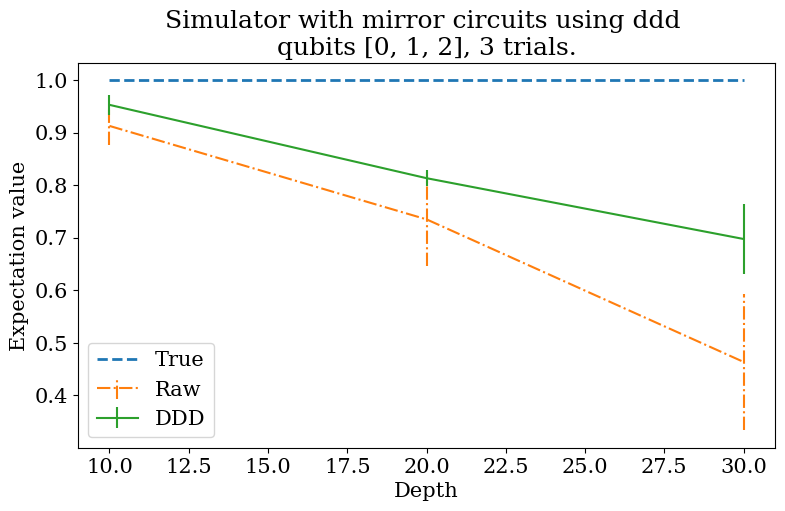

In [8]:
avg_true_values = np.average(true_values, axis=1)
avg_noisy_values = np.average(noisy_values, axis=1)

std_true_values = np.std(true_values, axis=1, ddof=1)
std_noisy_values = np.std(noisy_values, axis=1, ddof=1)

avg_ddd_values = np.average(ddd_values, axis=1)
std_ddd_values = np.std(ddd_values, axis=1, ddof=1)

plt.figure(figsize=(9, 5))

plt.plot(depths, avg_true_values, "--", label="True", lw=2)
eb = plt.errorbar(depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", ls="-.")
eb[-1][0].set_linestyle("-.")
plt.errorbar(depths, avg_ddd_values, yerr=std_ddd_values, label="DDD")

plt.title(
    f"""Simulator with mirror circuits using ddd \nqubits {qubits}, {trials} trials."""
)
plt.xlabel("Depth")
plt.ylabel("Expectation value")
_ = plt.legend()